In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch03":[-1.0,1.0],
        "AWA:Drive:DT8H_B_S:Ctrl":[-2.1,2.1]
        
    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Cx"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch03', 'AWA:Drive:DT8H_B_S:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

In [5]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
sys.path.append("../bax/")

from bax_alignment import ScipyBeamAlignment
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {}# {'Cx': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=False
)

algo = ScipyBeamAlignment(
    meas_dims=[0], 
    n_samples=10, 
    centroid_position_keys=['Cx']
)

#generator = BaxGenerator(
#    vocs=vocs, 
#    gp_constructor=model_constructor, 
#    algorithm=algo
#)

generator = BayesianExplorationGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
)

generator.numerical_optimizer.max_time = 1.0


In [7]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, strict=False)

In [8]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    max_time: 1.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: false
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    - 0.0
  objectives: {}
  o

In [9]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
#random_sample_region = get_local_region(current_value, X.vocs, fraction=0.5)

# create a mesh
n_samples = 2
xx = np.meshgrid(
    np.linspace(-1.0,1.0,n_samples)*0.5,
    np.linspace(-2.1,2.1,n_samples)*0.5+0.5
)
pts = np.vstack([ele.flatten() for ele in xx])
print(pts)
X.evaluate_data({"AWA:Bira3Ctrl:Ch03":pts[0],"AWA:Drive:DT8H_B_S:Ctrl":pts[1]})


#X.random_evaluate(2)#, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 0.713407, 'AWA:Drive:DT8H_B_S:Ctrl': 1.7299275345230758}
[[-0.5   0.5  -0.5   0.5 ]
 [-0.55 -0.55  1.55  1.55]]
fitting image


CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: 192.168.0.2:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Feb 27 2024 16:04:00.206251659
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: awa3.hep.anl.gov:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Feb 27 2024 16:04:00.207463905
..................................................................


104.42775013911638 155.0
fitting image
44.4767031719906 155.0
fitting image
274.5415718899089 155.0
fitting image
308.99209404833476 155.0


,AWA:Bira3Ctrl:Ch03,AWA:Drive:DT8H_B_S:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.5,-0.55,104.427750,124.076007,5.661921,26.750188,-20.273670,6650557.0,6.822858,-50.572250,-30.923993,59.277701,1.709071e+09,2.327053,False
1,0.5,-0.55,44.476703,175.855948,34.147787,5.380409,51.900382,6676178.0,6.824528,-110.523297,20.855948,112.473862,1.709071e+09,2.425840,False
2,-0.5,1.55,274.541572,124.876289,6.350569,24.056376,-111.137476,6544736.0,6.815892,119.541572,-30.123711,123.278649,1.709071e+09,2.542060,False
3,0.5,1.55,308.992094,182.001751,3.728809,5.650781,-222.710408,6228167.0,6.794360,153.992094,27.001751,156.341484,1.709071e+09,2.273110,False


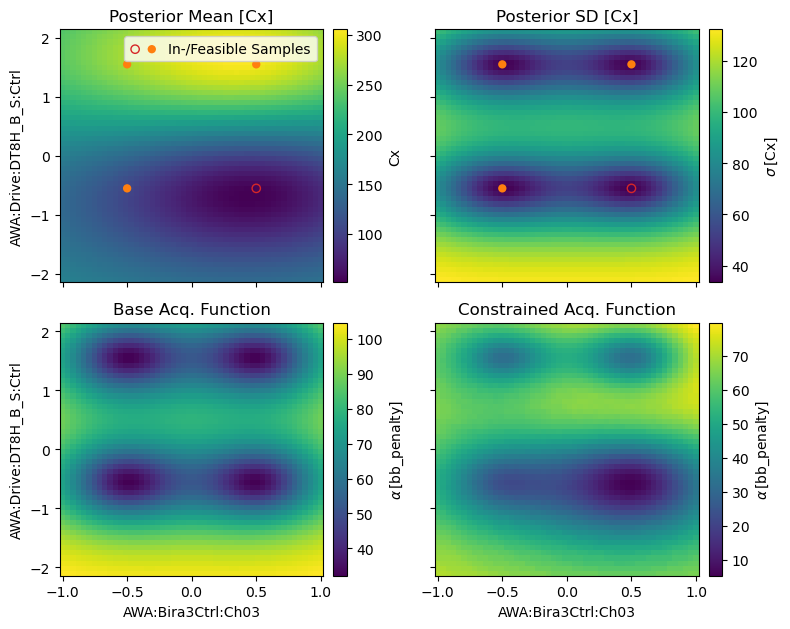

In [10]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [16]:
for i in range(20):
    X.step()

fitting image
308.8111502583288 155.0
fitting image
201.77142512549767 155.0
fitting image
193.64491068503446 155.0
fitting image
268.86317660453534 155.0
fitting image
86.22590785611906 155.0
fitting image
131.05839662354828 155.0
fitting image
227.3927328081586 155.0
fitting image
215.97160782129845 155.0
fitting image
130.107071347645 155.0
fitting image
93.94922787181453 155.0
fitting image
241.80845665482784 155.0
fitting image
187.375869513165 155.0
fitting image
134.47742431523835 155.0
fitting image
182.2375431473811 155.0
fitting image
200.4708082856065 155.0
fitting image
126.69603032328212 155.0
fitting image
310.0 155.0
fitting image
170.750297772009 155.0
fitting image
nan 155.0
fitting image
249.11340804027802 155.0


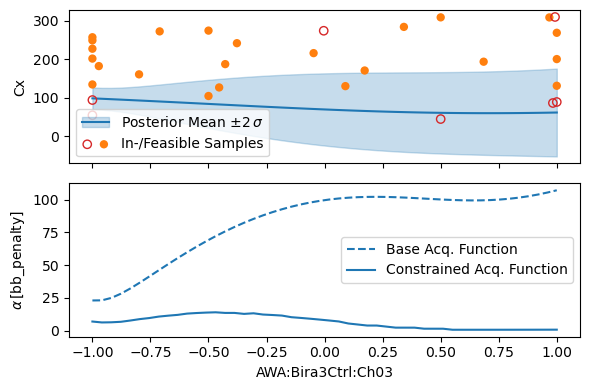

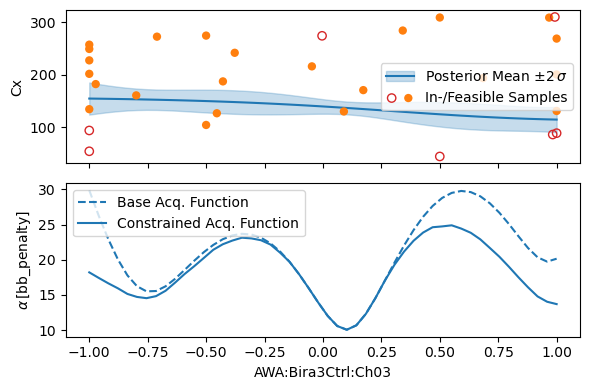

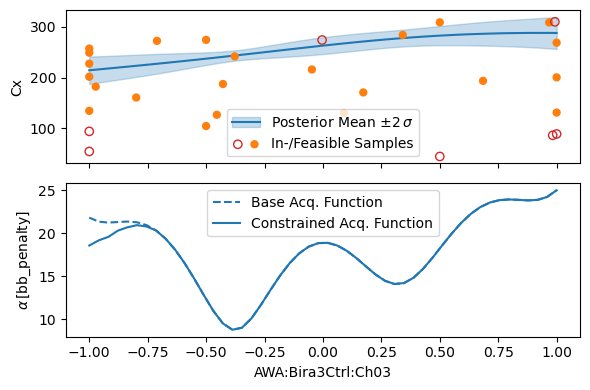

In [17]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":-1.1},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

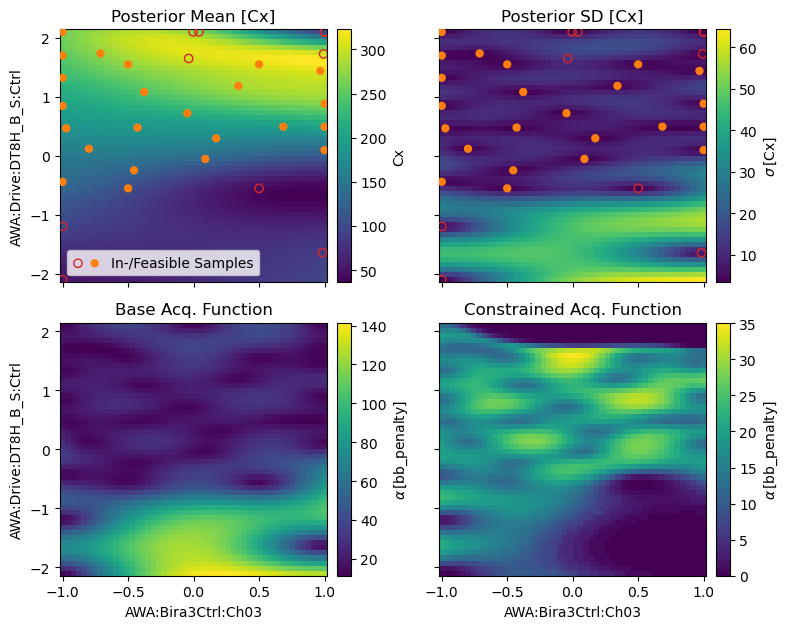

In [18]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


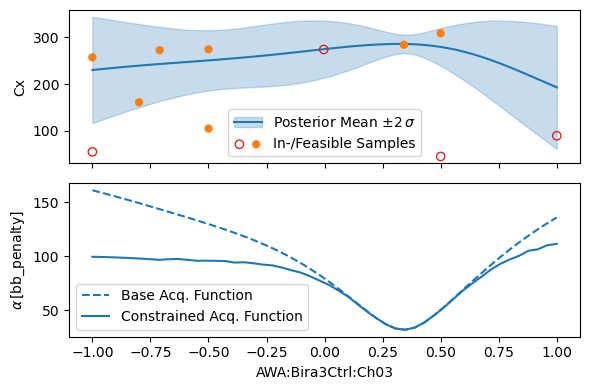

In [14]:
fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    output_names=["Cx"]
)


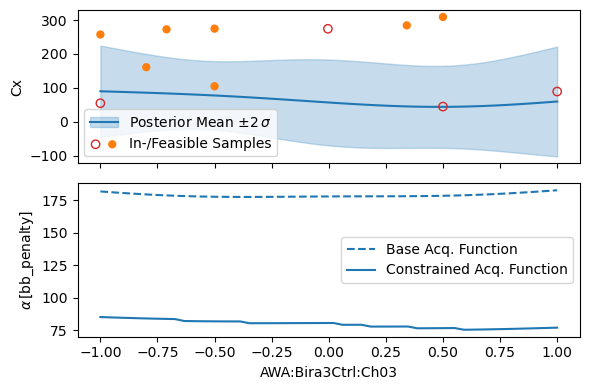

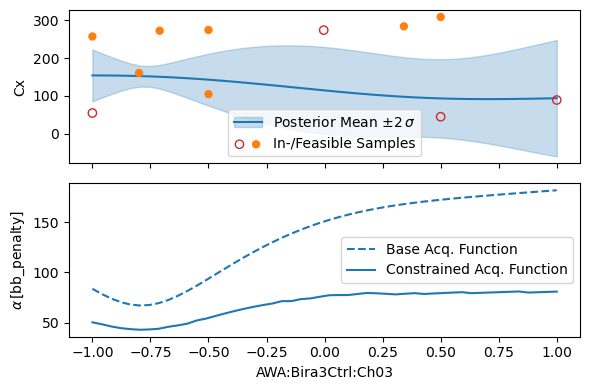

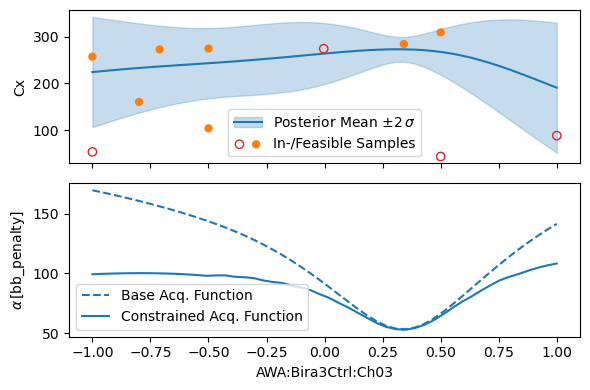

In [15]:
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":-1.1},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

In [21]:
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Cx': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=False
)

algo = ScipyBeamAlignment(
    meas_dims=[0], 
    n_samples=10, 
    centroid_position_keys=['Cx']
)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo
)

from xopt import Xopt
X2 = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, strict=False)
X2.add_data(X.data)


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:344: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  Lnn = torch.cholesky(K.to_dense())
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:224: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse 

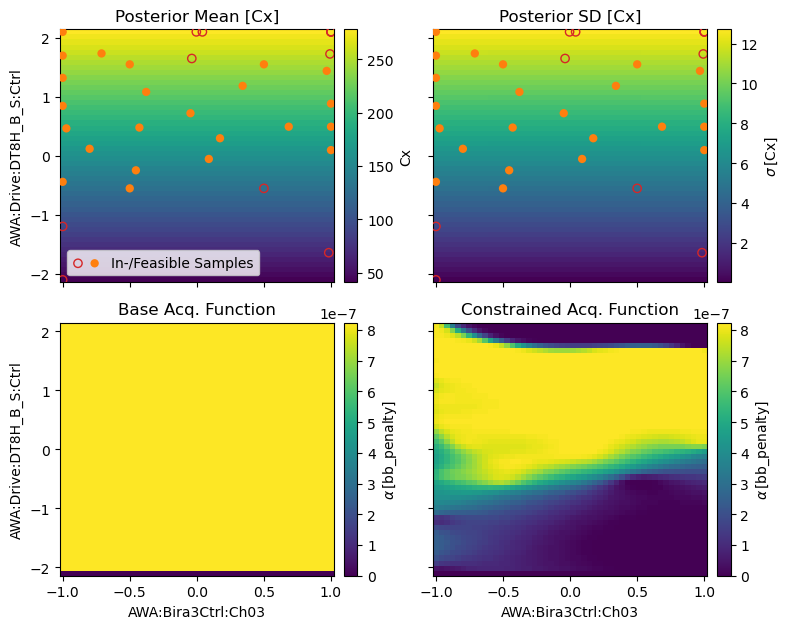

In [22]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X2.generator.train_model()
fig,ax = visualize_generator_model(
    X2.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

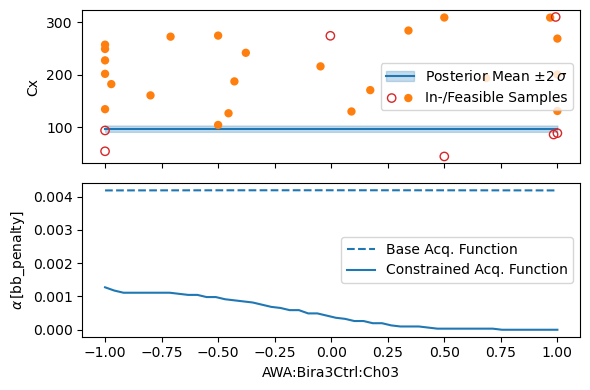

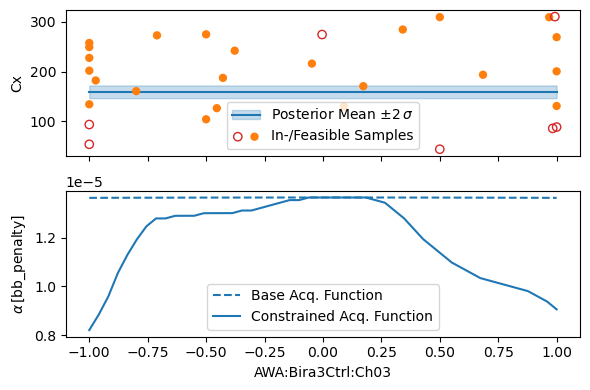

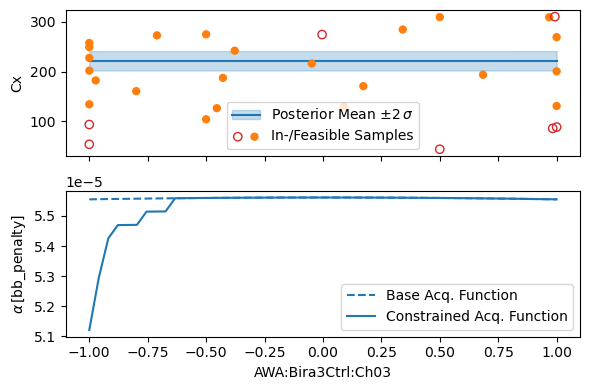

CA.Client.Exception...............................................
    Context: "192.168.0.166:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Tue Feb 27 2024 16:47:47.751218871
..................................................................


In [24]:
fig,ax = visualize_generator_model(
    X2.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":-1.1},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X2.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X2.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)